## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import subprocess
import sys
import warnings
import os
from IPython.display import display, HTML
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'
    
if 'darwin' in sys.platform:
    print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
    subprocess.Popen('caffeinate')

os.chdir(work_dir)
dir_to_save = '/Users/gabrieletocci/Documents/projects/CODE/data_sats4u/'

Running 'caffeinate' on MacOSX to prevent the system from sleeping


In [2]:
! pip install -r requirements.txt

In [3]:
import json
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import re

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)


## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [5]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

In [6]:
crypto.binance_client.get_account()

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'updateTime': 1651961431781,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locke

### Generate Candles and build features from technical analysis

In [7]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [8]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

798

,Close,Pred Close
Date,,
2022-05-13 15:00:00,30643.97,30501.118054
2022-05-13 15:15:00,30554.20,30525.952078
2022-05-13 15:30:00,30350.36,30573.904953
2022-05-13 15:45:00,30339.99,30584.163268
2022-05-13 16:00:00,30472.20,30600.028632
...,...,...
2022-07-04 03:30:00,19119.90,19460.261597
2022-07-04 03:45:00,19103.54,19446.736595
2022-07-04 04:00:00,19089.05,19460.248504


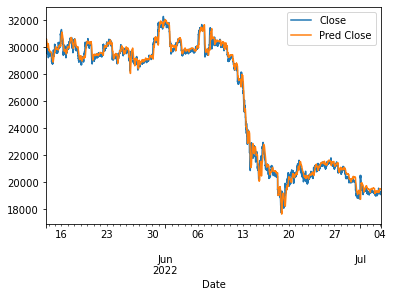

In [10]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

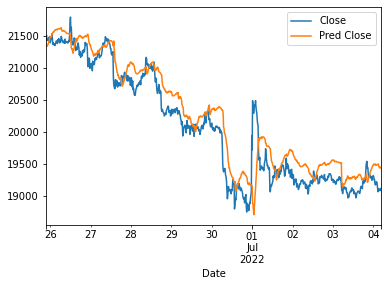

In [11]:
df_preds_true.iloc[-new_time_steps:].dropna().plot()


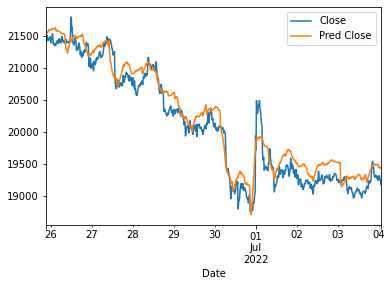

In [22]:
df_preds_shifted_true = tu.merge_true_preds(can_btc.candles, preds, period=-15+1)
df_preds_shifted_true.iloc[-new_time_steps:].dropna().plot()


Initial time 2022-06-25 21:30:00
Final time 2022-07-04 04:30:00
Fee: 0.025
----------------------
Buy      581 ( 320 ok 261 ko )
Avg PCT gain: 1.002131682817632
Avg PCT loss: 0.9979528451575396
Wins  PCT   0.5507745266781411
Avg PCT Gain.    1.002131682817632
No-op    0
Wallet   2290.1482499999993
Drawback -432.0785000000009
Kelly Fraction    0.10342230051329471
Total earned 2290.1482499999993


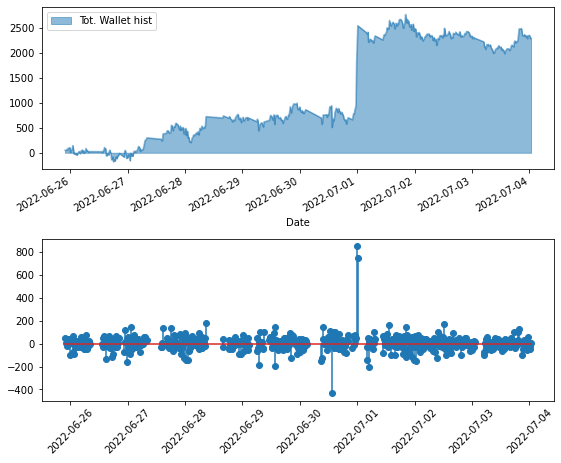

In [20]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps:].dropna(), step_back=+ 15,
                                                    long_short = "long", fee=0.025, cutoff_long = 10. ,cutoff_short = 10.0)
s2b.show_backtest_results(wallet,wallet_hist_df)


In [24]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')
  if sleep:
    print(f"Sleep for {min_till_close} mins.")
    time.sleep(min_till_close*dt_unit + 10)
    print(f"finished to sleep at {pd.Timestamp(datetime.now())}")


non_decimal = re.compile(r'[^\d.]+')
n_klines = crypto.kline_size
n_klines = non_decimal.sub('',n_klines)

#example: 
# a='123.f.'
# non_decimal.sub('', a )
# a='123'


In [25]:
crypto_test.binance_client.get_account()

{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'updateTime': 1656897336094,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.01900000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '9634.18297734', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [27]:
# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = 15
cutoff_long = 10.

verbose = True

total_wallet_history = []
single_wallet_history = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.1*delta_date

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = crypto.kline_size,
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test = False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(step_back,delta_date)

    prev_true_close = df_preds_true_shifted.iloc[-2,0]
    pred_close = df_preds_true_shifted.iloc[-1,1]

    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep=False)

    if open_position == False :

        if prev_true_close*(1+fee/cutoff_long) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001
            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                        side='BUY',
                                                        type='MARKET',
                                                        quantity= buy_quantity)
                                                        
            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position :

                time.sleep(60)
                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (est_close_time - current_time - buffer_delta )

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(f'Time until close of position: {time_until_close} mins.')
                    print(f'Position will be closed at {time_until_close + current_time}')
                
                if (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    order_close_time = pd.Timestamp(datetime.now())
                    profit = filled_close_price - filled_open_price
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True                    
        else:
            old_profit_negative = False
            old_profits = 0
            prev_close_date = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
            print(f'Order not filled Sleep for {crypto.kline_size}')
            
        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist"],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")


Current Time: 2022-07-04 05:23:57.313574
Minutes till Next Close: 6.050000000000001
Sleep for 6.050000000000001 mins.
finished to sleep at 2022-07-04 05:30:10.314895
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 05:30:38.856437
Minutes till Next Close: 14.366666666666667
-----------------------------------
Order filled at 2022-07-04 05:30:40.350442
Order will be closed around 2022-07-04 05:45:00
Filled open price: 19125.29
Previous close price: 19226.6
Predicted close price: 19478.781553548568
--------------------------------
Current price: 19123.8
Current time: 2022-07-04 05:31:40.946459
Time until close of position: 0 days 00:11:49.053541 mins.
Position will be closed at 2022-07-04 05:43:30
time_until_close.seconds/crypto.dt 11.816666666666666
--------------------------------
Current price: 19130.84
Current time: 2022-07-04 05:32:41.620245
Time 

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 05:42:49.362499,9.71,9.71


Current Time: 2022-07-04 05:42:50.050709
Minutes till Next Close: 2.166666666666666
Sleep for 2.166666666666666 mins.
finished to sleep at 2022-07-04 05:45:10.051212
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 05:45:40.352692
Minutes till Next Close: 14.333333333333334
-----------------------------------
Order filled at 2022-07-04 05:45:41.622764
Order will be closed around 2022-07-04 06:00:00
Filled open price: 19129.24
Previous close price: 19228.41
Predicted close price: 19482.486854177707
--------------------------------
Current price: 19138.72
Current time: 2022-07-04 05:46:42.223558
Time until close of position: 0 days 00:11:47.776442 mins.
Position will be closed at 2022-07-04 05:58:30
time_until_close.seconds/crypto.dt 11.783333333333333
--------------------------------
Current price: 19136.56
Current time: 2022-07-04 05:47:42.844623
Tim

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 05:42:49.362499,9.71,9.71
2022-07-04 05:57:49.657630,20.86,11.15


Current Time: 2022-07-04 05:57:50.320300
Minutes till Next Close: 2.166666666666666
Sleep for 2.166666666666666 mins.
finished to sleep at 2022-07-04 06:00:10.322828
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 06:00:37.317201
Minutes till Next Close: 14.383333333333333
-----------------------------------
Order filled at 2022-07-04 06:00:38.616621
Order will be closed around 2022-07-04 06:15:00
Filled open price: 19137.52
Previous close price: 19203.37
Predicted close price: 19476.68668393492
--------------------------------
Current price: 19133.5
Current time: 2022-07-04 06:01:39.240316
Time until close of position: 0 days 00:11:50.759684 mins.
Position will be closed at 2022-07-04 06:13:30
time_until_close.seconds/crypto.dt 11.833333333333334
--------------------------------
Current price: 19130.21
Current time: 2022-07-04 06:02:40.475195
Time 

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 05:42:49.362499,9.71,9.71
2022-07-04 05:57:49.657630,20.86,11.15
2022-07-04 06:12:47.234232,44.95,24.09


Current Time: 2022-07-04 06:12:48.706542
Minutes till Next Close: 2.1999999999999993
Sleep for 2.1999999999999993 mins.
finished to sleep at 2022-07-04 06:15:10.714527
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 06:15:37.752963
Minutes till Next Close: 14.383333333333333
-----------------------------------
Order filled at 2022-07-04 06:15:39.675784
Order will be closed around 2022-07-04 06:30:00
Filled open price: 19178.38
Previous close price: 19137.35
Predicted close price: 19474.647459295385
--------------------------------
Current price: 19169.97
Current time: 2022-07-04 06:16:40.300984
Time until close of position: 0 days 00:11:49.699016 mins.
Position will be closed at 2022-07-04 06:28:30
time_until_close.seconds/crypto.dt 11.816666666666666
--------------------------------
Current price: 19165.99
Current time: 2022-07-04 06:17:40.851007
T

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 05:42:49.362499,9.71,9.71
2022-07-04 05:57:49.657630,20.86,11.15
2022-07-04 06:12:47.234232,44.95,24.09
2022-07-04 06:27:49.377720,29.31,-15.64


Current Time: 2022-07-04 06:27:50.043986
Minutes till Next Close: 2.166666666666666
Sleep for 2.166666666666666 mins.
finished to sleep at 2022-07-04 06:30:10.045797
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 06:30:39.284661
Minutes till Next Close: 14.35
-----------------------------------
Order filled at 2022-07-04 06:30:40.571284
Order will be closed around 2022-07-04 06:45:00
Filled open price: 19167.29
Previous close price: 19072.49
Predicted close price: 19471.089454185956
--------------------------------
Current price: 19170.0
Current time: 2022-07-04 06:31:41.052620
Time until close of position: 0 days 00:11:48.947380 mins.
Position will be closed at 2022-07-04 06:43:30
time_until_close.seconds/crypto.dt 11.8
--------------------------------
Current price: 19176.85
Current time: 2022-07-04 06:32:41.630326
Time until close of position: 0

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 05:42:49.362499,9.71,9.71
2022-07-04 05:57:49.657630,20.86,11.15
2022-07-04 06:12:47.234232,44.95,24.09
2022-07-04 06:27:49.377720,29.31,-15.64
2022-07-04 06:42:48.978940,36.23,6.92


Current Time: 2022-07-04 06:42:49.643195
Minutes till Next Close: 2.1833333333333336
Sleep for 2.1833333333333336 mins.
finished to sleep at 2022-07-04 06:45:10.645937
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 06:45:38.376771
Minutes till Next Close: 14.366666666666667
-----------------------------------
Order filled at 2022-07-04 06:45:39.679040
Order will be closed around 2022-07-04 07:00:00
Filled open price: 19173.89
Previous close price: 19112.28
Predicted close price: 19473.043574747437
--------------------------------
Current price: 19163.7
Current time: 2022-07-04 06:46:40.918295
Time until close of position: 0 days 00:11:49.081705 mins.
Position will be closed at 2022-07-04 06:58:30
time_until_close.seconds/crypto.dt 11.816666666666666
--------------------------------
Current price: 19160.54
Current time: 2022-07-04 06:47:41.538249
Ti

In [59]:
wall_hist = pd.read_csv(work_dir + "data/live_wallet_history.csv",index_col=0)
wall_hist.index = pd.to_datetime(wall_hist.index)
wall_hist

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-03 19:21:23.325812,10,20
2022-07-03 19:36:15.747795,30,40
